In [3]:
import numpy as np
from enum import Enum
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import copy
import time

In [4]:
#Vamos a implementar esta nueva versión con direcciones a ver que tal funciona
Decisions = {}
Decisions['UP'] = 0
Decisions['DOWN'] = 1
Decisions['RIGHT'] = 2
Decisions['LEFT'] = 3
Decisions['LIFT_TREASURE'] = 4
Decisions['NOTHING'] = 5
Decisions['RANDOM_DIR'] = 6

CellType = {}
CellType['EMPTY'] = 0
CellType['TREASURE'] = 1
CellType['WALL'] = 2

In [5]:
class MightyTraveler:
    def __init__(self):
        numberOfGenes = 3**(9)
        #Vamos a tener 243 genes cada uno me va a decir la estrategia a tomar para el caso especifico
        self.position = np.zeros(2)
        self.directions = np.array([[1,0],[-1,0],[0,1],[0,-1]])
    
    def setGenotype(self, genotype):
        self.genotype = genotype
    
    #Aquí surroundings se va a pasar como un arreglo 
    #el cual tendrá 9 posiciones N S E O C
    
    def move(self,surroundings):
        index = 0
        for i in range(0,9):
            index += surroundings[i]*(3**(i))
        prevPos = []
        prevPos.append(self.position[0])
        prevPos.append(self.position[1])
        index = int(index)
        decision = self.genotype[index]
        #Up
        if(decision == 0):
            self.position[1] += 1
        #Down
        elif(decision == 1):
            self.position[1] -= 1
        #Right
        elif(decision == 2):
            self.position[0] += 1
        #Left
        elif(decision == 3):
            self.position[0] -= 1
        #Random
        elif(decision == 6):
            self.position += random.choice(self.directions)
        #Else we do nothing
        return decision, prevPos

In [6]:
class Map:
    
    #Vamos a inicializar el mapa con el ancho y largo que nos proporcione el usuario
    def __init__(self,width:int,height:int):
        self.width = width
        self.height = height
        self.region = np.zeros((self.height,self.width))
        self.posTilesX = range(1,self.width-2)
        self.posTilesY = range(1,self.height-2)
        #Ponemos las paredes
        for i in range(0,width):
            self.region[0,i] = 2
            self.region[height-1,i] = 2
        for i in range(0,height):
            self.region[i,0] = 2
            self.region[i,width-1] = 2
    
    #Colocamos aleatoriamente algunos tesoros
    def placeTreasures(self,n):
        objectsPlaced = 0
        treasuresPositions = np.zeros((n,2))
        while(objectsPlaced < n):
            #Elegimos una posición aleatoria para el objeto a colocar
            randX = random.choice(self.posTilesX)
            randY = random.choice(self.posTilesY)
            #Nos aseguramos de que 1.- no haya una pared en la posición y 
            #2.-No haya un objeto ya colocado ahi
            
            if(self.region[randY,randX] == 0):
                self.region[randY,randX] = 1
                treasuresPositions[objectsPlaced,:]  = [randX,randY]
                objectsPlaced += 1
        self.treasuresPositions = treasuresPositions
        self.numTreasures = n
    
    def resetTreasures(self):
        for i in range(0,self.numTreasures):
            treasure = self.treasuresPositions[i,:]
            self.region[int(treasure[1]),int(treasure[0])] = 1
    
    def getSurroundings(self,posX,posY):
        x = int(posX)
        y = int(self.height-1-posY)
        surroundings = [self.region[y-1,x],self.region[y+1,x],self.region[y,x+1],self.region[y,x-1],self.region[y,x], self.region[y-1, x-1], self.region[y-1, x+1], self.region[y+1, x-1], self.region[y+1, x+1]]
        return surroundings
    
    def getCellType(self,posX,posY):
        x = int(posX)
        y = int(self.height-1-posY)
        
        return self.region[y,x]
    
    def takeCellOut(self,posX,posY):
        x = int(posX)
        y = int(self.height-posY-1)
        self.region[y,x] = 0
    
    
    

class MapArtist:
    #m es un mapa con el cual se inicializa al artista
    def __init__(self,m):
        self.map = m
        self.wallColor = "#EC3E18"
        self.emptySpaceColor = "#BFAB7A"
        self.treasureColor = "#FFE614"
        self.tileSize = 10
        
    #Receives an axis, clears it and draws a map
    def drawMap(self,ax):
        ax.clear()
        gridX = np.linspace(0,self.map.width*self.tileSize,self.map.width)
        gridY = np.linspace(0,self.map.height*self.tileSize,self.map.height)
        for i in range(0,self.map.width):
            for j in range(0,self.map.height):
                xCorner = gridX[i]
                yCorner = gridY[j]
                cellType = self.map.getCellType(i,j)
                #Pinta todas las celdas con su color adecuado
                #Pared
                if(cellType == 2):
                    rect = patches.Rectangle((xCorner,yCorner),self.tileSize,self.tileSize,fill = True, edgecolor = self.wallColor, facecolor = self.wallColor) 
                #Celda vacia    
                elif(cellType == 0):
                    rect = patches.Rectangle((xCorner,yCorner),self.tileSize,self.tileSize,fill = True, edgecolor = self.emptySpaceColor, facecolor = self.emptySpaceColor)
                #Tesoro
                elif(cellType == 1):
                    rect = patches.Rectangle((xCorner,yCorner),self.tileSize,self.tileSize,fill = True, edgecolor = self.treasureColor, facecolor = self.treasureColor)
                ax.add_patch(rect)
    def getDrawingWidth(self):
        return self.map.width*self.tileSize + self.tileSize
    def getDrawingHeight(self):
        return self.map.height*self.tileSize + self.tileSize
    
    def setMap(self,stage):
        self.map.region = stage
        

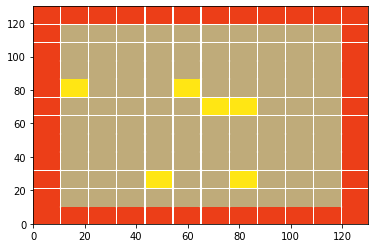

In [7]:
#Probamos el dibujado del mapa
stage = Map(12,12)
stage.placeTreasures(6)
artist = MapArtist(stage)
fig,ax = plt.subplots()
artist.drawMap(ax)
plt.ylim([0,artist.getDrawingHeight()])
plt.xlim([0,artist.getDrawingWidth()])
plt.show()

In [8]:
#Vamos a implementar la clase GameMaster que va a conducir experimentos con sus marionetas los viajeros busca tesoros.

class PuppetMaster:
    
    def __init__(self):
        self.fig,self.ax = plt.subplots()
    
    
    def play(self,puppet,stage,steps):
        #Colocamos al puppet en medio del tablero
        puppet.position = np.array([np.floor(stage.width/2),np.floor(stage.height/2)])
        score = 0
        for i in range(0,steps):
            position = puppet.position
            #start = time.time()
            surroundings = stage.getSurroundings(position[0],position[1])
            #end = time.time()
            #print("surreoundings time "+str(end-start))
            #start = time.time()
            decision,prevPos = puppet.move(surroundings)
            #end = time.time()
            #print("movement time "+str(end-start))
            newPos = puppet.position
            #Si decide moverse hacia una pared entonces lo penalizamos y lo regresamos a la posición donde estaba
            if(decision == 0 or decision == 1 or decision == 2 or decision == 3 or decision == 6):
                cellType = stage.getCellType(newPos[0],newPos[1])
                #If we hit a wall
                if(cellType == 2):
                    puppet.position = prevPos
                    score  -= 1
            #If lift treasure
            elif(decision == 4):
                cellType = stage.getCellType(newPos[0],newPos[1])
                #If there is a treasure
                if(cellType == 1):
                    stage.takeCellOut(newPos[0],newPos[1])
                    score += 10
                #If there is no treasure
                elif(cellType == 0):
                    #print("treasure lifted incorrectly")
                    score -= 3
        return score
    
    def playRun(self,puppet,stage,steps):
        positions = np.zeros((steps,2))
        maps = np.zeros((stage.height,stage.width,steps))
        #Colocamos al puppet en medio del tablero
        puppet.position = np.array([np.floor(stage.width/2),np.floor(stage.height/2)])
        score = 0
        for i in range(0,steps):
            position = puppet.position
            surroundings = stage.getSurroundings(position[0],position[1])
            decision,prevPos = puppet.move(surroundings)
            newPos = puppet.position
            positions[i,:] = newPos
            #Si decide moverse hacia una pared entonces lo penalizamos y lo regresamos a la posición donde estaba
            if(decision == Decisions['UP'] or decision == Decisions['DOWN'] or decision == Decisions['LEFT'] or decision == Decisions['RIGHT'] or decision == Decisions['RANDOM_DIR']):
                newPosition = puppet.position
                if(stage.getCellType(newPosition[0],newPosition[1]) == CellType['WALL']):
                    puppet.position = prevPos
                    score  -= 1
            elif(decision == Decisions['LIFT_TREASURE']):
                if(stage.getCellType(newPos[0],newPos[1]) == CellType['TREASURE']):
                    stage.takeCellOut(newPos[0],newPos[1])
                    score += 10
                elif(stage.getCellType(newPos[0],newPos[1]) == CellType['EMPTY']):
                    #print("Lifted incorrectly")
                    score -= 3
            maps[:,:,i] = stage.region
        
        return [maps, positions, score]
    
    
    def plotMap(self,i):
        pos = self.positions[i,:]
        self.mapHolder.setMap(self.maps[:,:,i])
        self.mapHolder.drawMap(self.ax)
        self.ax.plot(self.mapHolder.tileSize+pos[0]*self.mapHolder.tileSize,pos[1]*self.mapHolder.tileSize+self.mapHolder.tileSize,marker = 'o',markersize = 5)
        
    def obtainPlayAnimation(self,puppet,stage,steps):
        [self.maps,self.positions,self.score] = self.playRun(puppet,stage,steps)
        print(self.score)
        self.mapHolder = MapArtist(Map(stage.width, stage.height))
        anim = FuncAnimation(self.fig, self.plotMap, frames = steps, interval = 50, blit = False)
        return HTML(anim.to_html5_video())
        
        
    
    
                    
            
            
            
            
        
        
        
        

0


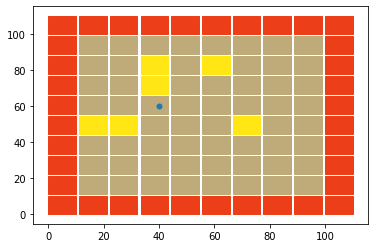

In [12]:
#Prueba del puppet master
puppet = MightyTraveler()
#Inicializamos aleatoriamente un genotipo 

genotype = np.zeros((3**9,1))
#
decisions = [0,1,2,3,4,5,6]

for i in range(0,3**9):
    genotype[i] = random.choice(decisions)
    
puppet.setGenotype(genotype)

#Ahora inicializamos el mapa
stage = Map(10,10)
stage.placeTreasures(6)
#Creamos un master of puppets para jugar con nuestro mapa y caminante
master = PuppetMaster()
master.obtainPlayAnimation(puppet,stage,100)

#print(master.score)


    

In [13]:
#Ok, parece estar funcionando 
#Ahora si crearemos nuestra clase para realizar los experimentos genéticos


class Darwin:
    
    def __init__(self,nMaps,mapSize,nTreasures):
        self.puppetMaster = PuppetMaster()
        self.maps = []
        self.nMaps = nMaps
        self.mapSize = mapSize
        self.nTreasures = nTreasures
        for i in range(0,nMaps):
            m = Map(mapSize,mapSize)
            m.placeTreasures(nTreasures)
            self.maps.append(m)
        self.mutationProbability = 0.01
        self.numberOfMutations = 990
        self.decisions = [0,1,2,3,4,5,6]
        self.thresholdForGoatInclusion = 20
    
    
    #Función de inicialización de la población 
    def initializePopulation(self, populationSize):
        #start = time.time()
        population = []
        for i in range(0,populationSize):
            puppet = MightyTraveler()
            puppet.setGenotype(np.array(random.choices(self.decisions,k = 3**9)))
            population.append(puppet)
        self.population = population
        self.populationSize = populationSize
        #end = time.time()
        #print("Initialization time "+str(end-start))
    #Función para evaluar a la población
    
    def evaluatePopulation(self,steps,maps):
        #start = time.time()
        scores = np.zeros(self.populationSize)
        #Jugamos en cada mapa
        for j in range(0,len(maps)):
            for i in range(0,self.populationSize):
                maps[j].resetTreasures()
                puppet = self.population[i]
                #print(maps[j].region)
                score = self.puppetMaster.play(puppet,maps[j],steps)
                scores[i] += score
        maxScore = np.max(scores)
        index = np.argmax(scores)
        maxPuppet = self.population[index]
        #end = time.time()
        #print("Evaluation time "+str(end-start))
        
        return scores,maxScore,maxPuppet
    
    
    
    def selectPopulation(self, scores, goatScore, goat):
        #start = time.time()
        #Vamos a seleccionar una nueva población
        minScore = np.min(scores)
        maxScore = np.max(scores)
        intervalSize = maxScore - minScore
        if(intervalSize != 0):
            normalizedScores = np.abs(scores-minScore)/intervalSize
            probabilities = normalizedScores/sum(normalizedScores)
            self.population = random.choices(self.population,weights = probabilities,k = self.populationSize)
        
        else:
            #Hacemos la selección en forma aleatoria
            self.population = random.choices(self.population,k = self.populationSize)
        
        if(goatScore-maxScore > self.thresholdForGoatInclusion):
            minInd = np.argmin(scores)
            self.population[minInd] = goat
        #end = time.time()
        #print("Selection time "+str(end-start))
    
    #Vamos a hacer una cruza 
    def crossPopulation(self):
        #start = time.time()
        #Punto de cruza aleatorio
        crossPop  = self.population
        random.shuffle(crossPop)
        crossedPop = []
        i = 0
        while(i <= self.populationSize-2):
            crossPoint = random.randrange(0,3**9)
            child1 = MightyTraveler()
            child2 = MightyTraveler()
            genotype1 = np.zeros(3**9)
            genotype2 = np.zeros(3**9)
            parent1 = crossPop[i]
            parent2 = crossPop[i+1]
            n = len(parent1.genotype)
            genotype1[0:crossPoint+1] = parent1.genotype[0:crossPoint+1]
            genotype1[crossPoint+1:n] = parent2.genotype[crossPoint+1:n]
            genotype2[0:crossPoint+1] = parent2.genotype[0:crossPoint+1]
            genotype2[crossPoint+1:n] = parent1.genotype[crossPoint+1:n]

            child1.setGenotype(genotype1)
            child2.setGenotype(genotype2)
            crossedPop.append(child1)
            crossedPop.append(child2)
            i += 2
        self.population = crossedPop
        #end = time.time()
        #print("crossover time "+str(end-start))
    
    def mutate(self):
        #start = time.time()
        for i in range(0,len(self.population)):
            dice = random.random()
            if(dice < self.mutationProbability):
                indicesToMutate = []
                for j in range(0,self.numberOfMutations):
                    indicesToMutate.append(random.randrange(0,3**9-1))
                
                for j in range(0,self.numberOfMutations):
                    self.population[i].genotype[indicesToMutate[j]] = random.choice(self.decisions)
        #end = time.time()
        #print("evolvetime "+str(end-start))
    
    def evolve(self,generations,steps):
        bestScores = []
        goat = None
        goatScore = float('-inf')
        for i in range(1,generations):
            #Evaluamos a la población
            
            scores, bestScore,maxPuppet = self.evaluatePopulation(steps,self.maps)
            #Agregamos el mejor puntaje a un arreglo
            bestScores.append(bestScore)
            #Si el goat es el mejor de la historia lo guardamos
            if(bestScore >= goatScore):
                goatScore = bestScore
                goat = maxPuppet
                print("New best score "+str(bestScore))
                print("generation " +str(i))
            #Seleccionamos a la población
            self.selectPopulation(scores,goatScore,goat)
            #Comencemos con un crosspoint a la mitad a ver que tal funciona
            self.crossPopulation()
            self.mutate()
            self.reshuffleMaps()
        return maxPuppet, bestScores,goat, goatScore
    
    def reshuffleMaps(self):
        self.maps = []
        for i in range(0,self.nMaps):
            m = Map(self.mapSize,self.mapSize)
            m.placeTreasures(self.nTreasures)
            self.maps.append(m)
    
    
    
    
       

New best score 10.0
generation 1
New best score 40.0
generation 2
New best score 40.0
generation 4
New best score 40.0
generation 11
New best score 40.0
generation 18
New best score 40.0
generation 20
New best score 40.0
generation 23
New best score 60.0
generation 24
New best score 80.0
generation 101
New best score 80.0
generation 173
New best score 90.0
generation 183
New best score 90.0
generation 186
New best score 110.0
generation 216
New best score 110.0
generation 298
New best score 120.0
generation 300
New best score 120.0
generation 307
New best score 120.0
generation 315
New best score 130.0
generation 328
New best score 130.0
generation 353
New best score 130.0
generation 359
New best score 140.0
generation 372
New best score 140.0
generation 379
New best score 150.0
generation 383
New best score 150.0
generation 388
New best score 160.0
generation 394
New best score 160.0
generation 398
New best score 190.0
generation 403
New best score 220.0
generation 423
New best score 

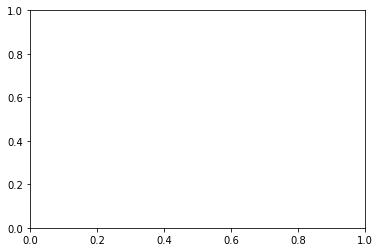

In [14]:
#Probemos
steps = 1000
generations = 15000
populationSize = 200
nMaps = 10
nTreasures = 6
mapSize = 10
#Creamos un darwin
darwin = Darwin(nMaps,mapSize,nTreasures)
darwin.initializePopulation(populationSize)
#%prun lastPuppet, bestScores,goat, goatScore = darwin.evolve(generations,steps)
lastPuppet, bestScores,goat, goatScore = darwin.evolve(generations,steps)

In [ ]:
3**(5)

#### print(bestScores[0])

(0.0, 600.0)

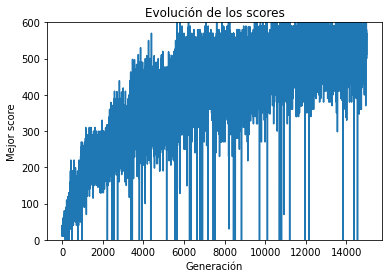

In [15]:

plt.figure()
plt.title("Evolución de los scores")
plt.plot(bestScores)
plt.xlabel("Generación")
plt.ylabel("Mejor score")
plt.ylim([0,600])

60


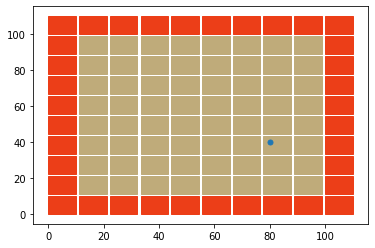

In [34]:
stage = Map(10,10)
stage.placeTreasures(6)
master = PuppetMaster()
master.obtainPlayAnimation(goat,stage,1000)


In [ ]:

stage = Map(10,10)
stage.placeTreasures(6)
master = PuppetMaster()
master.obtainPlayAnimation(goat,darwin.maps[8],100)

In [29]:
s = ""
for i in range(0,len(goat.genotype)):
    s += str(int(goat.genotype[i]))
    s += ", "
print(s)

6, 0, 5, 1, 0, 1, 4, 3, 5, 6, 0, 5, 3, 6, 2, 3, 2, 5, 6, 2, 0, 0, 3, 3, 3, 6, 5, 3, 0, 3, 6, 3, 5, 1, 6, 3, 3, 6, 3, 3, 3, 0, 3, 0, 3, 2, 3, 5, 3, 0, 2, 0, 3, 4, 1, 5, 4, 2, 0, 5, 4, 3, 0, 0, 2, 0, 3, 6, 2, 1, 1, 0, 6, 5, 1, 2, 4, 0, 5, 1, 4, 4, 4, 0, 4, 6, 1, 2, 0, 2, 1, 2, 6, 4, 0, 4, 3, 0, 0, 0, 2, 4, 2, 3, 0, 5, 4, 1, 4, 4, 1, 0, 5, 4, 5, 5, 1, 4, 3, 6, 4, 1, 5, 2, 0, 3, 1, 2, 5, 2, 2, 2, 2, 6, 1, 2, 4, 4, 6, 3, 5, 6, 1, 2, 6, 1, 3, 1, 4, 2, 0, 1, 2, 1, 3, 0, 5, 6, 0, 4, 6, 2, 3, 3, 2, 6, 1, 0, 4, 3, 4, 4, 3, 0, 2, 3, 4, 3, 2, 0, 4, 1, 6, 1, 0, 3, 3, 6, 2, 4, 2, 1, 1, 5, 5, 2, 4, 1, 4, 2, 6, 3, 6, 5, 0, 3, 6, 4, 6, 0, 1, 4, 1, 2, 4, 5, 2, 4, 0, 3, 6, 2, 6, 5, 6, 5, 6, 0, 3, 6, 5, 5, 5, 1, 1, 1, 3, 4, 5, 0, 1, 5, 0, 6, 0, 4, 5, 6, 3, 5, 3, 1, 2, 5, 5, 1, 5, 2, 3, 2, 4, 5, 2, 3, 2, 6, 4, 1, 3, 0, 2, 5, 6, 5, 1, 3, 3, 3, 4, 0, 6, 4, 6, 4, 5, 6, 2, 2, 3, 5, 5, 0, 1, 2, 0, 1, 1, 6, 1, 3, 1, 3, 4, 2, 4, 1, 6, 3, 6, 5, 6, 1, 2, 5, 3, 1, 2, 5, 1, 0, 1, 1, 6, 5, 4, 6, 5, 6, 4, 3, 4, 0, 1, 4

In [ ]:
np.abs(np.max(a)-np.min(a))

In [ ]:
a = [1,2,3,4,5]
w = [0.9,0.02,0.02,0.02,0.04]
w2 = [np.nan,np.nan,np.nan,np.nan,np.nan]
random.choices(a,weights = w2)

In [ ]:
random.shuffle(a)
print(a)

In [ ]:
random.choice([0,1,2,3,4,5,6])

In [ ]:
random.randrange(0,200)

In [ ]:
a = np.array([1,2,3,4,5])
b = np.abs(a-14)/3
b[0:2] = [1,2]
print(b)

In [ ]:
a = np.array([1,2,3,4,5])
a = random.choices(a,k=4)
print(a)

In [ ]:
np.zeros(5)

In [ ]:
np.array(random.choices([0,1,2,3,4,5,6],k = 3**5))

In [ ]:
darwin.population[0].genotype

In [ ]:
darwin.population[2].genotype

In [ ]:
score =0

In [ ]:
score+=10
print(score)

In [ ]:
for i in range(0,10):
    print(darwin.population[i].genotype)

In [ ]:
CellType(2)

In [ ]:
a = 5

def proeba(x):
    x = x+4
    y = x
    return x

proeba(a)

In [ ]:
class objeto:
    a = 5
    
    def getA(self):
        return self.a
    
    def setA(self,a):
        self.a = a

In [ ]:
o = objeto()
y = o.a
x = o.getA()
o.setA(8)
print(x)
print(y)

In [60]:
2*3**0 +2*3**1  +2*3**2 +2*3**3+2*3**4

242

In [78]:
np.argmin([1,1,2,3])

0

In [13]:
goat.genotype

array([6., 1., 1., 6., 3., 1., 0., 6., 0., 2., 3., 1., 6., 0., 0., 5., 4.,
       4., 1., 0., 6., 5., 3., 0., 3., 0., 0., 3., 6., 2., 3., 5., 1., 5.,
       4., 0., 3., 5., 5., 6., 3., 2., 0., 4., 4., 3., 4., 4., 5., 5., 6.,
       2., 4., 3., 2., 2., 2., 0., 0., 3., 2., 1., 2., 0., 0., 3., 0., 5.,
       6., 5., 6., 1., 4., 4., 0., 5., 1., 3., 4., 4., 6., 4., 4., 3., 4.,
       1., 1., 2., 4., 0., 4., 0., 1., 1., 1., 5., 1., 4., 2., 5., 4., 0.,
       5., 0., 4., 0., 1., 2., 4., 3., 0., 3., 3., 6., 3., 5., 5., 1., 0.,
       5., 5., 0., 6., 0., 2., 0., 0., 5., 6., 4., 2., 4., 2., 0., 4., 4.,
       4., 5., 5., 5., 4., 6., 0., 1., 6., 1., 6., 5., 2., 4., 2., 3., 1.,
       2., 5., 4., 4., 3., 6., 5., 6., 6., 0., 1., 0., 0., 1., 3., 2., 3.,
       3., 5., 2., 2., 5., 3., 6., 6., 0., 6., 5., 6., 2., 5., 1., 6., 0.,
       2., 5., 6., 0., 1., 0., 5., 4., 0., 6., 2., 1., 3., 3., 0., 0., 1.,
       3., 4., 1., 6., 2., 1., 4., 0., 6., 1., 2., 1., 0., 5., 1., 4., 2.,
       1., 3., 2., 5., 4.

In [19]:
0.05*3**9

984.1500000000001

In [18]:
10/200

0.05